In [1]:
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

from nltk.corpus import stopwords
stopwords = stopwords.words('english')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from IPython.display import Image as im
style.use('fivethirtyeight')

from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

In [2]:
stopwords.append('inquirer')
stopwords.append('cookies')
stopwords.append('repo')
stopwords.append('exec')
stopwords.append('dutee')
stopwords.append('said')
stopwords.append('yolanda')

In [3]:
df = pd.read_excel('./Scraped/questionnaires.xlsx')

In [4]:
df.head()

,questionnaire name,content
0,Burn's Depression Checklist,Feeling sad or down in the dumps\nFeeling unha...
1,Patient Health Questionnaire (PHQ-9),Little interest or pleasure in doing things\nF...
2,Beck's Depression Inventory,I do not feel sad.\nI feel sad\nI am sad all t...
3,Personal Inventory for Depression and SAD Self...,Were there two weeks or more . . .\nwhen you h...
4,Center for Epidemiologic Studies Depression Scale,I was bothered by things that usually don’t bo...


In [5]:
len(df)

5

# Cleaning

In [6]:
def clean_text(df):
    df['cleaned_text'] = df['content'].fillna('')
    df['cleaned_text'] = df['cleaned_text'].str.lower()
    df['cleaned_text'] = df['cleaned_text'].str.replace(r'(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|rt|\d+', '')
    df['cleaned_text'] = df['cleaned_text'].str.replace(r'^\s+|\s+$', '') 
    df['cleaned_text'] = df['cleaned_text'].apply(lambda x: ' '.join([w for w in x.split() if w not in (stopwords)]))
    df['cleaned_split'] = df['cleaned_text'].apply(lambda x: x.split())
    return df

In [7]:
def lemmatize_df(df):
    df['lemmatized'] = df['cleaned_split'].apply(lambda x : [lemmatizer.lemmatize(word) for word in x])
    return df

In [8]:
df = clean_text(df)
df = lemmatize_df(df)

In [9]:
df.head()

,questionnaire name,content,cleaned_text,cleaned_split,lemmatized
0,Burn's Depression Checklist,Feeling sad or down in the dumps\nFeeling unha...,feeling sad dumpsfeeling unhappy bluecrying sp...,"[feeling, sad, dumpsfeeling, unhappy, bluecryi...","[feeling, sad, dumpsfeeling, unhappy, bluecryi..."
1,Patient Health Questionnaire (PHQ-9),Little interest or pleasure in doing things\nF...,little interest pleasure thingsfeeling depress...,"[little, interest, pleasure, thingsfeeling, de...","[little, interest, pleasure, thingsfeeling, de..."
2,Beck's Depression Inventory,I do not feel sad.\nI feel sad\nI am sad all t...,feel sadi feel sadi sad time cant snap sad unh...,"[feel, sadi, feel, sadi, sad, time, cant, snap...","[feel, sadi, feel, sadi, sad, time, cant, snap..."
3,Personal Inventory for Depression and SAD Self...,Were there two weeks or more . . .\nwhen you h...,two weeks trouble falling asleep staying aslee...,"[two, weeks, trouble, falling, asleep, staying...","[two, week, trouble, falling, asleep, staying,..."
4,Center for Epidemiologic Studies Depression Scale,I was bothered by things that usually don’t bo...,bothered things usually dont bother mei feel l...,"[bothered, things, usually, dont, bother, mei,...","[bothered, thing, usually, dont, bother, mei, ..."


In [10]:
len(df)

5

# Analysis

In [11]:
def tweets_to_dtm(tweets):
    tweets = tweets['cleaned_text']
    vectorizer = CountVectorizer(max_features=2000)
    dtm = vectorizer.fit_transform(tweets)
    pickle.dump(vectorizer, open('out/dtm.pk', 'wb'))
    return dtm, vectorizer

def tweets_to_ngram(tweets, n=2):
    tweets = tweets['cleaned_text']
    vectorizer = CountVectorizer(
        ngram_range=(n, n),
        token_pattern=r'\b\w+\b',
        min_df=1,
        max_features=2000)
    dtm = vectorizer.fit_transform(tweets)
    pickle.dump(vectorizer, open('out/ngram.pk', 'wb'))
    return dtm, vectorizer

def tweets_to_tfidf(tweets):
    tweets = tweets['cleaned_text']
    vectorizer = TfidfVectorizer(max_features=2000)
    tfidf = vectorizer.fit_transform(tweets)
    pickle.dump(vectorizer, open('out/tfidf.pk', 'wb'))
    return tfidf, vectorizer

In [12]:
# Get TFIDF matrix
tfidf, tfidf_v = tweets_to_tfidf(df)
print('TFIDF matrix shape:', tfidf.toarray().shape)
list(tfidf_v.vocabulary_.items())[0:5]

TFIDF matrix shape: (5, 329)


[('feeling', 110),
 ('sad', 240),
 ('dumpsfeeling', 76),
 ('unhappy', 301),
 ('bluecrying', 31)]

In [13]:
def vector_to_frequency(vector, vectorizer):
    """
    Return a list of words and their corresponding occurence in the corpus
    """
    total = vector.sum(axis=0)
    frequency = [(w, total[0, i]) for w, i in vectorizer.vocabulary_.items()]
    frequency = pd.DataFrame(frequency, columns=['term', 'frequency'])
    frequency = frequency.sort_values(by='frequency', ascending=False).reset_index(drop=True)
    return frequency

In [14]:
freq_tfidf = vector_to_frequency(tfidf, tfidf_v)
freq_tfidf.to_csv('out/frequency_tfidf.csv', index=False)
freq_tfidf.head(20)

,term,frequency
0,felt,0.815493
1,tend,0.565353
2,feel,0.506056
3,interest,0.480608
4,little,0.450480
5,family,0.391687
6,used,0.383222
7,feeling,0.372018
8,sleeping,0.362860
9,dont,0.338116


Text(0.5, 1.0, 'Frequent terms in TFIDF')

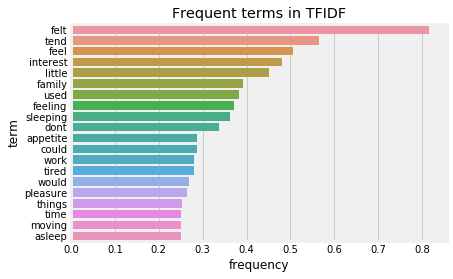

In [15]:
# Visualize frequencies
sns.barplot(data=freq_tfidf.head(20), x='frequency',
            y='term').set_title('Frequent terms in TFIDF')

In [16]:
df.head()

,questionnaire name,content,cleaned_text,cleaned_split,lemmatized
0,Burn's Depression Checklist,Feeling sad or down in the dumps\nFeeling unha...,feeling sad dumpsfeeling unhappy bluecrying sp...,"[feeling, sad, dumpsfeeling, unhappy, bluecryi...","[feeling, sad, dumpsfeeling, unhappy, bluecryi..."
1,Patient Health Questionnaire (PHQ-9),Little interest or pleasure in doing things\nF...,little interest pleasure thingsfeeling depress...,"[little, interest, pleasure, thingsfeeling, de...","[little, interest, pleasure, thingsfeeling, de..."
2,Beck's Depression Inventory,I do not feel sad.\nI feel sad\nI am sad all t...,feel sadi feel sadi sad time cant snap sad unh...,"[feel, sadi, feel, sadi, sad, time, cant, snap...","[feel, sadi, feel, sadi, sad, time, cant, snap..."
3,Personal Inventory for Depression and SAD Self...,Were there two weeks or more . . .\nwhen you h...,two weeks trouble falling asleep staying aslee...,"[two, weeks, trouble, falling, asleep, staying...","[two, week, trouble, falling, asleep, staying,..."
4,Center for Epidemiologic Studies Depression Scale,I was bothered by things that usually don’t bo...,bothered things usually dont bother mei feel l...,"[bothered, things, usually, dont, bother, mei,...","[bothered, thing, usually, dont, bother, mei, ..."


In [17]:
df.to_pickle('./Cleaned/questionnaire_cleaned.pkl')

In [18]:
"https://stackoverflow.com/questions/15424895/creating-lexicon-and-scanner-in-python"

'https://stackoverflow.com/questions/15424895/creating-lexicon-and-scanner-in-python'